<a href="https://colab.research.google.com/github/anne-urai/ddm_mediation/blob/main/generate_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, set Runtime -> Runtime type -> GPU for fitting

# https://hddm.readthedocs.io/en/latest/lan_tutorial.html
!pip install scikit-learn
!pip install cython
!pip install pymc

# after making changes to the hddm forked repo, factory reset runtime
!pip install -U --no-deps git+https://github.com/anne-urai/hddm
!pip install -U --no-deps git+https://github.com/hddm-devs/kabuki


# MODULE IMPORTS ----
# warning settings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# to download data
from google.colab import files
import pprint

# HDDM
import hddm

     |████████████████████████████████| 385 kB 7.4 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1361112 sha256=f0315833a1fa61e19319df9efad6066bbed1b6b7f1a16e350e1f69b597ad99be
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc
  Cloning https://github.com/anne-urai/hddm to /tmp/pip-req-build-2n569f19
  Running command git clone -q https://github.com/anne-urai/hddm /tmp/pip-req-build-2n569f19
  Running command git submodule update --init --recursive -q
  Created wheel for HDDM: filename=HDDM-0.9.3-cp37-cp37m-linux_x86_64.whl size=3875314 sha256=6fcf0bccb713754cdbe09a32ffda1ab0b6208e4cb89ca6c8b2a02a839ae84e79
  Stored in directory: /tmp/pip-ephem-wheel-cache-24lm7tc5/wheels/fa/1c/d6/4d91002b5305b3dc76ca13cd496b9bbfd0fc9350d27ab615ca
Successfully built HDDM
  Cloning https://github.com/hddm-devs/kabuki to /tmp/pip-req-build-za0s989m
  Running command git clone -q https:/

In [2]:
##  ============================================================= ##
## generate some artificial choice data with mediation variable
##  ============================================================= ##

# first, previous choices ('X')
n_trials = 500
n_subj = 20
df = pd.DataFrame(np.random.choice([-1,1], (n_trials*n_subj, 2)), 
                  columns=list('XS')) 

# then a normally distributed random variable, that depends on X
df['M'] = np.random.normal(size=n_trials*n_subj) + df['X']

# make sure we have subj_idx and trial_idx
subj_idx = []
for s in np.arange(n_subj) + 1:
  for n in np.arange(n_trials):
    subj_idx.append(s)

trial_idx = []
for s in np.arange(n_subj) + 1:
  for n in np.arange(n_trials):
    trial_idx.append(n)

df['subj_idx'] = subj_idx
df['trial_idx'] = trial_idx

df = df[['subj_idx', 'trial_idx', 'S', 'X', 'M']]
df.sample(n=10)


,subj_idx,trial_idx,S,X,M
8956,18,456,1,1,-0.787342
7426,15,426,-1,-1,-1.191718
5552,12,52,1,1,1.128452
2556,6,56,-1,-1,-1.664685
2987,6,487,1,1,0.422047
6789,14,289,1,1,0.398246
3637,8,137,-1,1,-0.051178
2744,6,244,1,-1,-2.283873
5506,12,6,1,-1,-0.487709
2378,5,378,1,-1,-0.913410


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmode

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: M          
No. Observations: 10000   Method:             REML       
No. Groups:       20      Scale:              0.9931     
Min. group size:  500     Likelihood:         -14219.2495
Max. group size:  500     Converged:          No         
Mean group size:  500.0                                  
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept     -0.011    0.210  -0.050 0.960 -0.421  0.400
X              1.008    0.010 101.038 0.000  0.988  1.027
Group Var      0.876                                     



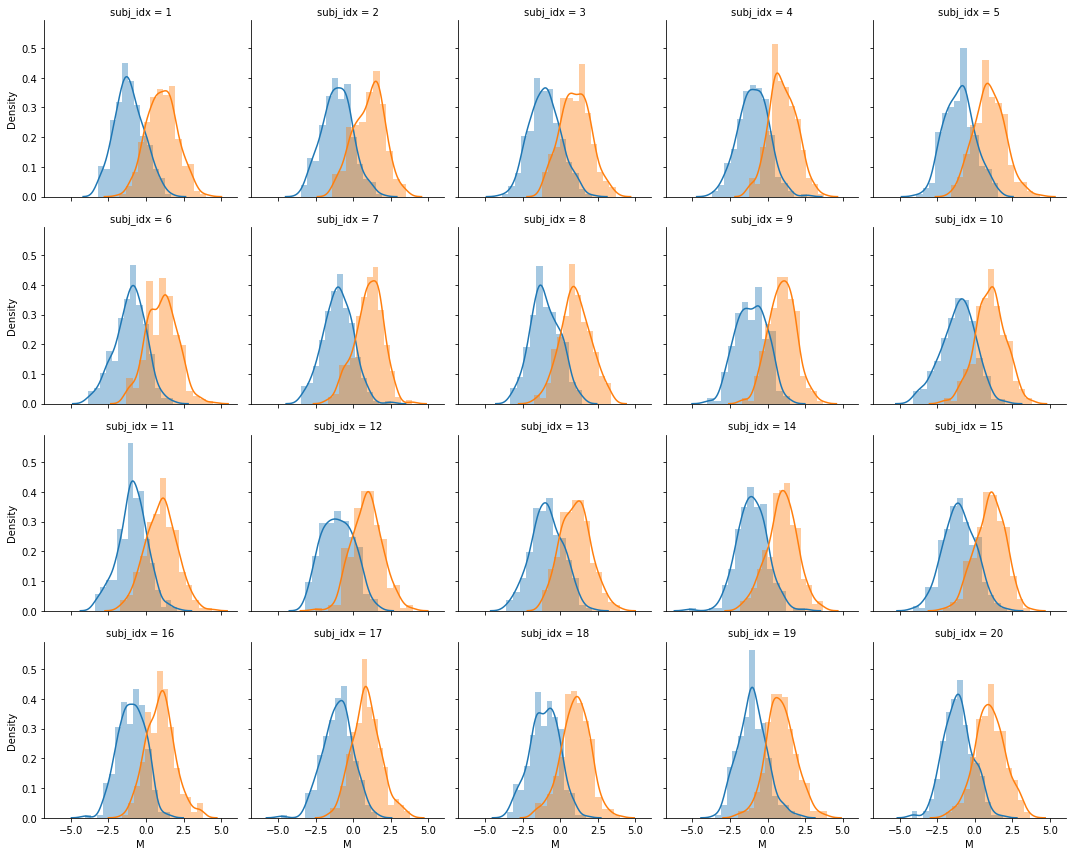

In [3]:
# DOES M DEPEND ON X (a-path)?
import statsmodels.formula.api as smf

md = smf.mixedlm("M ~ X", df, groups=df["subj_idx"])
mdf = md.fit()
print(mdf.summary())

# see the separation
g = sns.FacetGrid(data=df, col='subj_idx', col_wrap=5, hue='X')
g.map(sns.distplot, 'M')

In [7]:
##  ============================================================= ##
# plug into the HDDMnn simulator to simulate choices and RTs
##  ============================================================= ##

# help(hddm.simulators.hddm_dataset_generators.simulator_h_c)
# see https://hddm.readthedocs.io/en/latest/lan_tutorial.html#section-5-regressors 
# forum request for bug: https://groups.google.com/g/hddm-users/c/bdKDkwuQ3tk

for eff_x in ['v', 'z', 'no']:
  for eff_m in ['v', 'z', 'no']:

  # simulate a couple of datasets: where X/M affects v/z/nothing
    regr_v = 'v ~ 1 + S'
    if eff_x == 'v':
      regr_v = regr_v + ' + X'
    if eff_m == 'v':
      regr_v = regr_v + ' + M'

    regr_z = 'z ~ 1'
    if eff_x == 'z':
      regr_z = regr_z + ' + X'
    if eff_m == 'z':
      regr_z = regr_z + ' + M'

    print(regr_v, regr_z)

    # plug this into the simulator
    data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(data = df, 
                                                                                  model = 'ddm',
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, 
                                                                                  depends_on = None, 
                                                                                  regression_models = [regr_v, regr_z], 
                                                                                  regression_covariates = ['S', 'X'],
                                                                                  group_only = None,
                                                                                  group_only_regressors = False,
                                                                                  fixed_at_default = None)

    # export the parameter_dict into df
    # from https://github.com/anne-urai/MEG/blob/master/hddm_funcs_plot.py#L66
    # https://github.com/anne-urai/hddm/blob/master/hddm/utils.py#L925
    param_dict = {}
    for key, value in full_parameter_dict.items():
        if 'reg' not in key:
            param_dict[key] = value
    param_dict
    param_df = pd.DataFrame.from_dict(param_dict, orient='index').reset_index()
    param_df = hddm.utils.results_long2wide(param_df, 
                                            name_col="index", 
                                            val_col=0)

    # save the data and param_df to files for later fitting
    # see https://colab.research.google.com/notebooks/io.ipynb#scrollTo=p2E4EKhCWEC5
    param_df.to_csv('param_df_X%s_M%s.csv'%(eff_x, eff_m))
    files.download('param_df_X%s_M%s.csv'%(eff_x, eff_m))

    data.to_csv('data_df_X%s_M%s.csv'%(eff_x, eff_m))
    files.download('data_df_X%s_M%s.csv'%(eff_x, eff_m))

v ~ 1 + S + X + M z ~ 1
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v ~ 1 + S + X z ~ 1 + M
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v ~ 1 + S + X z ~ 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v ~ 1 + S + M z ~ 1 + X
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v ~ 1 + S z ~ 1 + X + M
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v ~ 1 + S z ~ 1 + X
new round of data simulation because parameter bounds where violated


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v ~ 1 + S + M z ~ 1
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v ~ 1 + S z ~ 1 + M
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v ~ 1 + S z ~ 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>